In [0]:
import torch
import torchvision
from torch.autograd import Variable

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

lr_find_fai = lr_find

from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import json

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
model_dir = root_dir + 'models/segmentation'
model_path = Path(model_dir)

Mounted at /content/gdrive


# **Data**

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_00780.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03570.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009390.png')]

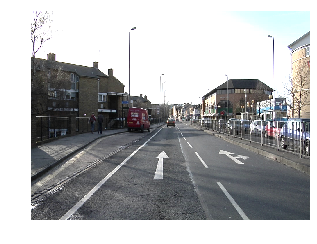

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

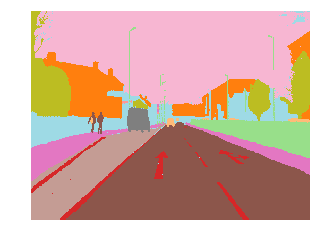

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 30, 30, 30],
          [26, 26, 26,  ..., 30, 30, 30],
          [26, 26, 26,  ..., 30, 30, 30],
          ...,
          [18, 18, 18,  ..., 17, 17, 17],
          [18, 18, 18,  ..., 17, 17, 17],
          [18, 18, 18,  ..., 17, 17, 17]]]))

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [0]:
#size = src_size//2
size = [224, 224]
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
print(len(data.train_ds), len(data.valid_ds), size, data.c)

600 101 [224, 224] 32


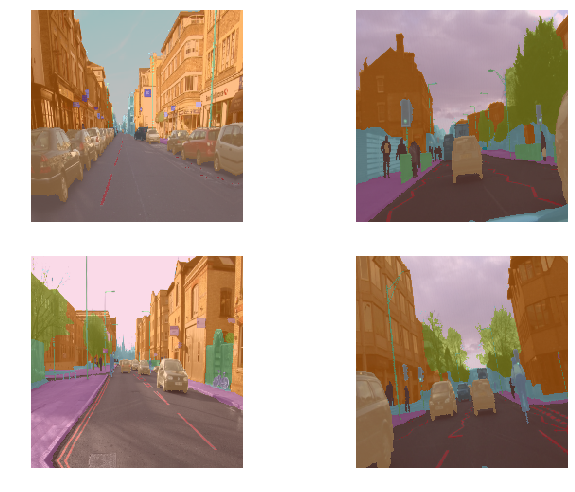

In [0]:
data.show_batch(2, figsize=(10,7))

# **Big images**

In [0]:
bs = 2
size = [512, 512]

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [15]:
print(len(data.train_ds), len(data.valid_ds), data, data.c)

600 101 ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /root/.fastai/data/camvid/images;

Test: None 32


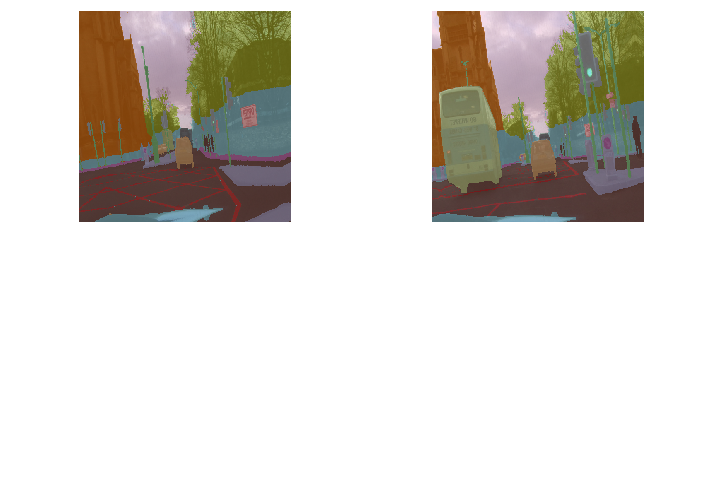

In [16]:
data.show_batch(2, figsize=(10,7))

# **Unet**

In [0]:
class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, resnet, n_classes=2):
        super().__init__()
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

# **Base model**

In [0]:
def change_feeze_state(model, should_train, model_params=None):
  params = None
  if model_params is not None:
    params = []
    for model_param in model_params:
      for param in model_param:
        params.append(param)
        
  for param in model.parameters() if params is None else params:
    param.requires_grad = should_train
    
def freeze_model(model, params=None):
  change_feeze_state(model, False, params)
  
def unfreeze_model(model, params=None):
  change_feeze_state(model, True, params)

In [0]:
resnet = torchvision.models.resnet.resnet50(pretrained=True)
freeze_model(resnet)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 93880796.18it/s]


# **Training utils**

In [0]:
def plot_losses(history):
  clear_output(wait=True)
  f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=False)
  ax1.plot(range(1, len(history['train_loss'])+1), history['train_loss'], label="loss")
  ax1.plot(range(0, len(history['train_loss'])+1, len(history['train_loss']) // (len(history['val_loss'])-1)), history['val_loss'], label="val loss")
  ax1.legend()
  ax2.plot(range(0, len(history['train_loss'])+1, len(history['train_loss']) // (len(history['val_loss'])-1)), history['val_acc'], label="val accuracy")
  ax2.legend()
  ax3.plot(range(len(history['lr_range'])), history['lr_range'], label="Learning rates")
  ax3.legend()
  ax4.plot(range(len(history['momentums'])), history['momentums'], label="Momentums")
  ax4.legend()
  plt.show()
  print('\n')
  #print('Training losses:', history['train_loss'])
  print('Val losses:', history['val_loss'])
  print('Val accuracy:', history['val_acc'])
  
def get_predicted_labels(scores):
  return torch.squeeze(torch.argmax(scores, dim=1))

def get_void_mask(labels):
  return torch.ne(labels, void_code)
  
def get_accuracy(scores, labels):
  predicted_labels = get_predicted_labels(scores)
  mask = get_void_mask(labels)
  total_sum = torch.sum(mask).type(torch.cuda.FloatTensor)
  acc_sum = torch.sum(torch.eq(predicted_labels, labels) * mask).type(torch.cuda.FloatTensor)
  return acc_sum / total_sum

def forward_pass(model, batch, calculate_accuracy=False, return_scores=False):
  loss_fn = torch.nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
  x, y = batch
  x_var = Variable(x.type(torch.cuda.FloatTensor))
  y_var = Variable(y.type(torch.cuda.FloatTensor).long())        
  
  scores = model(x_var)
  loss = loss_fn(scores, torch.squeeze(y_var, dim=1))
  
  values_to_return = [loss]
  if calculate_accuracy:
    accuracy = get_accuracy(scores, torch.squeeze(y_var))
    values_to_return.append(accuracy)
  if return_scores:
    values_to_return.append(scores)
    
  if len(values_to_return) == 1:
    return values_to_return[0]
  else:
    return values_to_return
  
def evaluate(model, data):
  model.eval()
  val_loss = []
  val_accuracy = []
  for t, batch in enumerate(tqdm(data.valid_dl)):
    loss, accuracy = forward_pass(model, batch, True)
    val_loss.append(loss.item())
    val_accuracy.append(accuracy.item())
  return np.mean(val_loss), np.mean(val_accuracy)

def get_lr_range(lrs, num_iter, turning_point=0.3, update_every=1):
  turning_iter = int(num_iter * turning_point)
  num_upward_steps = turning_iter // update_every
  num_downward_steps = (num_iter - turning_iter) // update_every
  upward_step = (lrs[1] - lrs[0]) / num_upward_steps
  downward_step = (lrs[1] - lrs[2]) / num_downward_steps
  lr_range = []
  current_lr = lrs[0]
  
  for i in range(turning_iter):
    if (i+1) % update_every == 0:
      current_lr += upward_step
    lr_range.append(current_lr)
  for i in range(turning_iter, num_iter + 1):
    if (i+1) % update_every == 0:
      current_lr -= downward_step
    lr_range.append(current_lr)
  
  return lr_range

def get_default_model_parameters(model_parameters):
  return list(map(lambda p: {'params': p['params'], 'lr': p['lr'][0]}, model_parameters))

def train(model, data, num_epochs, lr_range=None, mom_range=None, lr=None, weight_decay=0, model_parameters=None, group_rates=None):
  assert (lr_range is not None) or (lr is not None)
  
  history = {
      'train_loss': [],
      'val_loss': [],
      'val_acc': [],
      'lr_range': [],
      'momentums': [],
  }
  
  val_loss, val_accuracy = evaluate(model, data)
  history['val_loss'].append(val_loss.item())
  history['val_acc'].append(val_accuracy.item())
  print(f'\n Before training. Val loss: {val_loss}. Val accuracy: {val_accuracy}.')
  
  counter = 0
  
  if lr_range is None:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  elif model_parameters is None:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_range[counter], weight_decay=weight_decay)
  else:
    optimizer = torch.optim.Adam(get_default_model_parameters(model_parameters), lr=lr_range[counter], weight_decay=weight_decay)
  
  for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(data.train_dl):
      for group in optimizer.param_groups:
        group['betas'] = (mom_range[counter] if mom_range is not None else 0.9, 0.999)
      
      if (group_rates is None) & (lr_range is not None):
        for group in optimizer.param_groups:
          group['lr'] = lr_range[counter]
      elif group_rates is not None:
        for g, group in enumerate(optimizer.param_groups):
          group['lr'] = group_rates[g][counter]
      
      loss = forward_pass(model, batch)
      history['train_loss'].append(loss.item())
      history['lr_range'].append(lr_range[counter] if lr_range is not None else lr)
      history['momentums'].append(mom_range[counter] if mom_range is not None else 0.9)
          
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      #print('!!!!!!!!!!!!!!!!!!!!!!!!!!', model.up_blocks[3].conv_block_1.conv.weight.grad)
      #print('!!!!!!!!!!!!!!!!!!!!!!!!!!', model.down_blocks[0][0].conv1.weight.grad)
      counter += 1
          
    val_loss, val_accuracy = evaluate(model, data)
    history['val_loss'].append(val_loss.item())
    history['val_acc'].append(val_accuracy.item())
        
    plot_losses(history)
  
  return history
    
def train_one_cycle(model, data, num_epochs, lrs, momentums=None, weight_decay=0, model_parameters=None, turning_point=0.3):
  num_iter = len(data.train_dl) * num_epochs
  lr_range = get_lr_range(lrs, num_iter, turning_point)
  mom_range = get_lr_range(momentums, num_iter, turning_point) if momentums is not None else None
  
  group_rates = None
  if model_parameters is not None:
    group_rates = list(map(lambda p: get_lr_range(p['lr'], num_iter, turning_point), model_parameters))
  
  return train(model, data, num_epochs, lr_range=lr_range, mom_range=mom_range, weight_decay=weight_decay, model_parameters=model_parameters, group_rates=group_rates)

# **Hyper parameters**

In [0]:
def get_power_of_ten(number): 
  res = number if number >= 10 else 1/number
  power = 0
  while res >= 9.9:
    res /= 10
    power += 1
  return power if number >= 10 else -power

def lr_find(model, data, start_lr=1e-7, end_lr=10, num_iter=100, start_momentum=None, end_momentum=None, weight_decay=0):
  pow_range = range(get_power_of_ten(start_lr) * 10, (get_power_of_ten(end_lr) + 1) * 10, 5)
  lr_range = list(map(lambda p: pow(10, p/10), pow_range))
  update_every = num_iter // len(lr_range)

  history = {
      'loss': [],
      'lr': [],
  }
  
  mom_range = None
  if (start_momentum is not None) & (end_momentum is not None):
    assert end_momentum < start_momentum
    mom_range = [start_momentum]
    step = (end_momentum - start_momentum) / num_iter
    while mom_range[len(mom_range) - 1] > end_momentum:
      mom_range.append(mom_range[len(mom_range) - 1] + step)
  
  iter_count = 0
  current_lr_index = 0
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_range[current_lr_index], weight_decay=weight_decay)
  history['lr'].append(lr_range[current_lr_index])
  pbar = tqdm(total=num_iter)
  while (iter_count < num_iter) & (current_lr_index < len(lr_range)):
    for batch in data.train_dl:
      if (iter_count >= num_iter) | (current_lr_index >= len(lr_range)):
        break
      if (iter_count % update_every == 0) & (iter_count != 0):
        current_lr_index += 1
        if (current_lr_index >= len(lr_range)):
          break
        history['lr'].append("{:.3e}".format(lr_range[current_lr_index]))
        for group in optimizer.param_groups:
          group['lr'] = lr_range[current_lr_index]
          group['betas'] = (mom_range[current_lr_index] if mom_range is not None else 0.9, 0.999)
          
      loss = forward_pass(model, batch)
      if (iter_count > 10) and (loss.item() / np.array(history['loss'][iter_count-11:iter_count - 1]).mean() >= 5):
        iter_count = num_iter
        history['loss'].append(max(history['loss']))
        break
      history['loss'].append(loss.item())
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
          
      iter_count += 1
      pbar.update(1)
  
  clear_output(wait=True)
  plt.figure(figsize=(20,10))
  plt.plot(range(len(history['loss'])), history['loss'])
  plt.xticks(range(0, len(history['loss']), update_every), history['lr'])
  plt.show()
  pbar.close()

# **Training fastai**

In [0]:
model = torch.load(model_path/'init_pretrained.pt')

In [0]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def with_cross_entropy(fn):
  def wrapper (scores, target):
    loss_fn = torch.nn.CrossEntropyLoss()
    return fn(scores, target, loss_fn)
  return wrapper

@with_cross_entropy
def loss(scores, target, loss_fn):
  return loss_fn(scores, torch.squeeze(target))

def cross_entropy_loss(scores, target):
  loss_fn = torch.nn.CrossEntropyLoss()
  return loss_fn(scores, torch.squeeze(target))

In [0]:
learn = Learner(data, model, loss_func=cross_entropy_loss, metrics=acc_camvid)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


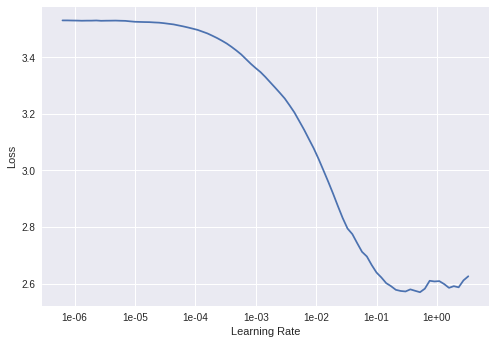

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.744225,2.262152,0.805668,01:50
1,2.206398,1.618715,0.818821,01:50
2,1.522576,1.077875,0.802910,01:51
3,1.024734,0.704038,0.839883,01:50
4,0.813560,0.654193,0.833927,01:50
5,0.708891,0.550183,0.854732,01:49
6,0.650443,0.813954,0.752436,01:51
7,0.608537,0.474387,0.865207,01:49
8,0.571987,0.536941,0.849346,01:50
9,0.525557,0.399268,0.886796,01:49


In [0]:
learn.save(model_path/'stage-1')

In [0]:
learn.load(model_path/'stage-1')
learn.unfreeze()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNetWithResnet50Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Bridge. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UpBlockForUNetWithResNet50. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be ch

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


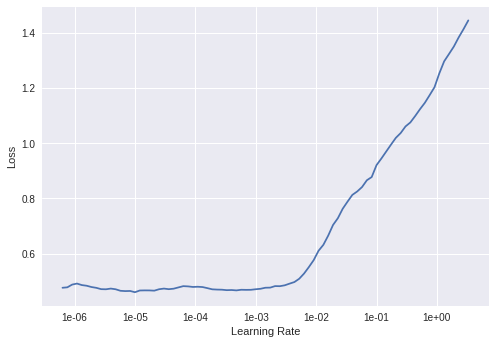

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lrs = slice(lr/400, lr/4)
learn.fit_one_cycle(12, slice(lr/4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.463716,0.376983,0.893636,02:04
1,0.453873,0.374960,0.892831,02:05
2,0.447306,0.377510,0.892265,02:05
3,0.447230,0.421470,0.879381,02:05
4,0.455915,0.466756,0.867352,02:04
5,0.449745,0.394900,0.895597,02:05
6,0.447408,0.436326,0.874458,02:05
7,0.433398,0.411104,0.886418,02:05
8,0.441608,0.401674,0.886238,02:04
9,0.417058,0.412013,0.885880,02:05


# **Training**

In [0]:
model = torch.load(model_path/'stage-2_clr-cyc_1.pt')
freeze_model(model, params=[
    model.input_block.parameters(),
    model.down_blocks.parameters(),
])
#model = UNetWithResnet50Encoder(resnet, n_classes=32).cuda()
#torch.save(model, model_path/'init_pretrained.pt')

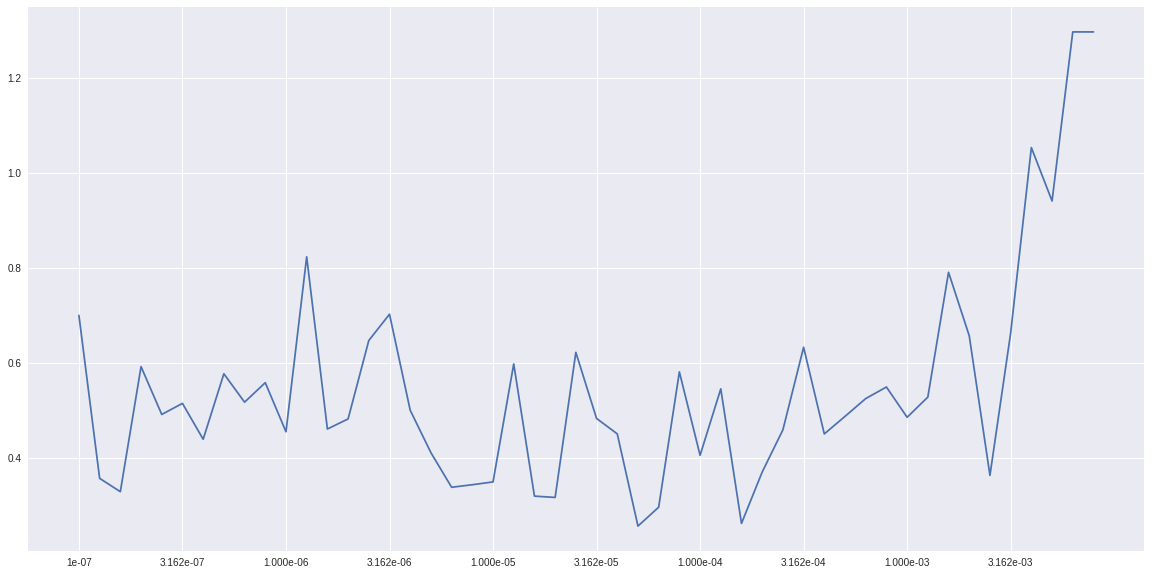

In [0]:
lr_find(model, data)

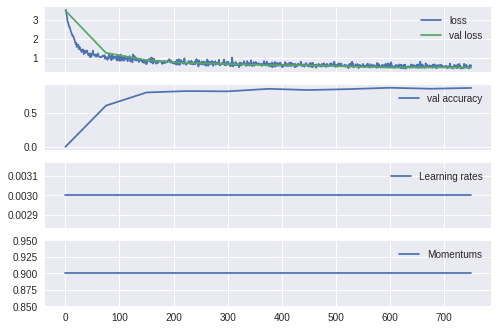



Val losses: [3.5010025868049035, 1.2694559188989492, 0.8885915371087881, 0.7355626821517944, 0.6827876017643855, 0.6206516348398649, 0.6150198532984807, 0.5521993912183322, 0.49487826915887684, 0.5056434915615962, 0.49153674107331496]
Val accuracy: [0.00014131898289913527, 0.6039476027855506, 0.7968320617308984, 0.8173692776606634, 0.812815615764031, 0.8495864638915429, 0.8325995298532339, 0.8459573342249944, 0.86546423802009, 0.8510721600972689, 0.8628849203769977]


In [0]:
model = torch.load(model_path/'init_pretrained.pt')
history = train(model, data, 10, lr=3e-3)
#torch.save(model, model_path/'stage-1_pretrained_fixed.pt')
#json.dump(history, open(model_path/"history_stage-1_pretrained_fixed.txt",'w'))

In [0]:
model = None
gc.collect()

5249

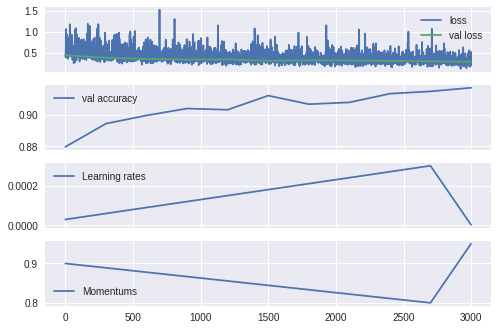



Val losses: [0.44710807589923635, 0.38719594069555696, 0.35965512313094794, 0.34643739286591024, 0.3481542532350503, 0.3173406495183122, 0.32878394512569203, 0.32525088535804375, 0.3148408383131027, 0.30429323835700167, 0.29415012720753164]
Val accuracy: [0.8796419045504402, 0.8944322455163095, 0.8996667487948549, 0.9040707443274704, 0.9032924864806381, 0.9123080513056587, 0.9068290053629408, 0.9080027704145394, 0.9135430209776935, 0.9150203256046071, 0.917304023808124]


In [0]:
model = torch.load(model_path/'stage-2_clr-cyc_1.pt')
freeze_model(model, params=[
    model.input_block.parameters(),
    model.down_blocks.parameters(),
])
history = train_one_cycle(model, data, 10, lrs=[3e-5, 3e-4, 3e-6], momentums=[0.9, 0.8, 0.95], turning_point=0.9)
# torch.save(model, model_path/'stage-1_clr-cyc_3.pt')
# json.dump(history, open(model_path/"history_stage-1_clr-cyc_3.txt",'w'))

In [0]:
torch.save(model, model_path/'stage-1-big_clr-cyc_40.pt')
json.dump(history, open(model_path/"history_stage-1-big_clr-cyc_40.txt",'w'))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNetWithResnet50Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Bridge. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UpBlockForUNetWithResNet50. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be ch

# **Unfreeze**

In [0]:
def get_lr_range_for_layer(lr_range_max, lr_range_min, num_steps, step):
  step_0 = (lr_range_max[0] - lr_range_min[0]) / num_steps
  step_1 = (lr_range_max[1] - lr_range_min[1]) / num_steps
  step_2 = (lr_range_max[2] - lr_range_min[2]) / num_steps
  return np.array(lr_range_max) - step * np.array([step_0, step_1, step_2])

def sum_params(params_gen, abs_value=True):
  s = torch.tensor(0).type(torch.cuda.FloatTensor)
  total = 0
  for param in params_gen:
    if abs_value == True:
      s += param.abs().sum()
    else:
      s += param.sum()
    total += np.prod(param.shape)
  print(s / total)

In [0]:
model = torch.load(model_path/'stage-1-big_clr-cyc_40.pt')
unfreeze_model(model)

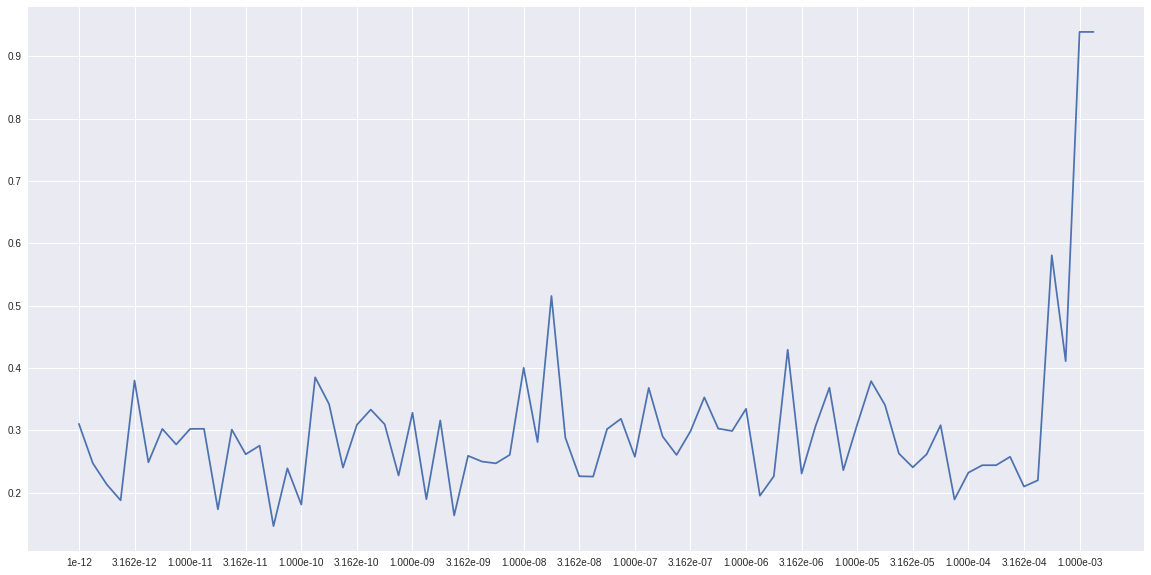

In [23]:
lr_find(model, data, start_lr=1e-12, end_lr=1e-1)

In [0]:
model = torch.load(model_path/'stage-1-big_clr-cyc_40.pt')
unfreeze_model(model)

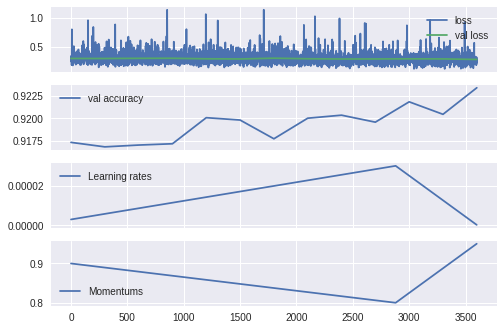



Val losses: [0.2941501248700946, 0.2933279795973909, 0.2959071681195614, 0.2971922971454321, 0.2880045645961575, 0.2852069186229332, 0.2983759977653915, 0.2887270374625337, 0.28481624436144737, 0.2854726317466474, 0.2873758054247089, 0.2860608886854321, 0.2770179796452616]
Val accuracy: [0.917304023808124, 0.9168039151266509, 0.9170045899409874, 0.9171484591914159, 0.9200572441605961, 0.919793943564097, 0.917704164981842, 0.9200002422519759, 0.9203355382470524, 0.9195579851374907, 0.9218246352438834, 0.9204331390997943, 0.9233928229294571]


In [25]:
# lrs_max = np.array([3e-4, 3e-3, 3e-5]) / 4
# lrs_min = np.array([3e-4, 3e-3, 3e-5]) / 100
lrs_max = np.array([3e-5, 3e-4, 3e-6]) / 10
lrs_min = np.array([1e-7, 1e-6, 1e-8])
num_steps = 5

history = train_one_cycle(model, data, 12, lrs=lrs_max, model_parameters=[
   {'params': model.input_block.parameters(), 'lr': get_lr_range_for_layer(lrs_max, lrs_min, num_steps, 5)},
    {'params': model.down_blocks[0].parameters(), 'lr': get_lr_range_for_layer(lrs_max, lrs_min, num_steps, 4)},
    {'params': model.down_blocks[1].parameters(), 'lr': get_lr_range_for_layer(lrs_max, lrs_min, num_steps, 3)},
    {'params': model.down_blocks[2].parameters(), 'lr': get_lr_range_for_layer(lrs_max, lrs_min, num_steps, 2)},
    {'params': model.down_blocks[3].parameters(), 'lr': get_lr_range_for_layer(lrs_max, lrs_min, num_steps, 1)},
    {'params': model.bridge.parameters(), 'lr': lrs_max},
    {'params': model.up_blocks.parameters(), 'lr': lrs_max},
    {'params': model.out.parameters(), 'lr': lrs_max},
], momentums=[0.9, 0.8, 0.95], turning_point=0.8)

#history = train_one_cycle(model, data, num_epochs=12, lrs=lrs_max / 50, momentums=[0.9, 0.8, 0.95], turning_point=0.8)

In [26]:
torch.save(model, model_path/'stage-2-big_clr-cyc_1.pt')
json.dump(history, open(model_path/"history_stage-2-big_clr-cyc_1.txt",'w'))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNetWithResnet50Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Bridge. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UpBlockForUNetWithResNet50. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be ch

# **Inference**

In [0]:
def infer(model, data, part):
  model.eval()
  val_loss = []
  val_accuracy = []
  length = int(len(data.valid_ds) * part)
  
  batches = np.zeros((length, 3, size[0], size[1]))
  true_labels = np.zeros((length, 1, size[0], size[1]))
  scores = np.zeros((length, data.c, size[0], size[1]))
  for t, batch in enumerate(tqdm(data.valid_dl)):
    if t >= int(len(data.valid_dl) * part):
      break
    
    loss, accuracy, batch_scores = forward_pass(model, batch, calculate_accuracy=True, return_scores=True)
    val_loss.append(loss.item())
    val_accuracy.append(accuracy.item())
    batches[t * data.batch_size : t * data.batch_size + data.batch_size,:,:,:] = data.denorm(batch[0]).cpu().detach().numpy()
    true_labels[t * data.batch_size : t * data.batch_size + data.batch_size,:,:,:] = batch[1].cpu().detach().numpy()
    scores[t * data.batch_size : t * data.batch_size + data.batch_size,:,:,:] = batch_scores.cpu().detach().numpy()
  
  return np.mean(val_loss), np.mean(val_accuracy), batches, true_labels, np.expand_dims(scores.argmax(axis=1), axis=1)

In [0]:
model = torch.load(model_path/'stage-2-big_clr-cyc_1.pt')

In [26]:
loss, accuracy, images, true_labels, predictions = infer(model, data, 0.3)
print('Loss:', loss)
print('Accuracy:', accuracy)

 29%|██▉       | 15/51 [00:12<00:28,  1.27it/s]

Loss: 0.2765642116467158
Accuracy: 0.9234873374303182


In [0]:
def show_prediction(images, predictions, true_labels, index):
  fig = plt.figure()
  
  img = images[index]
  img = img.swapaxes(0,1)
  img = img.swapaxes(1,2)
  plt.imshow(img, interpolation='nearest')
  plt.show()

  mask = ImageSegment(tensor(predictions[index]))
  mask.show()

  true_mask = ImageSegment(tensor(true_labels[index]))
  true_mask.show()
  
def show_random_predictions(images, predictions, true_labels, size):
  indices = np.random.choice(range(images.shape[0]), size=size)
  for i in indices:
    show_prediction(images, predictions, true_labels, i)

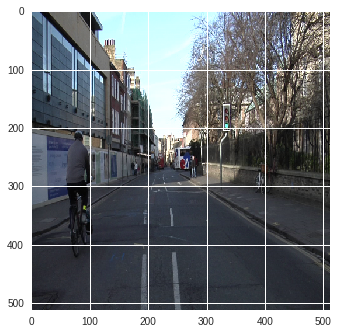

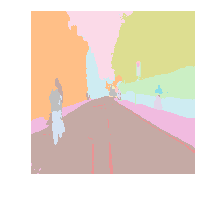

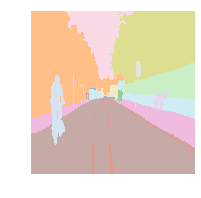

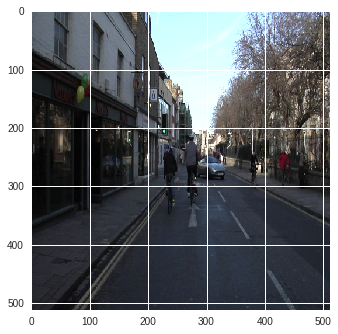

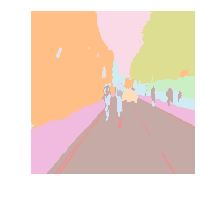

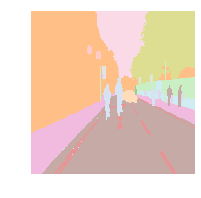

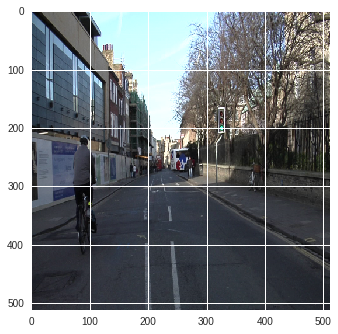

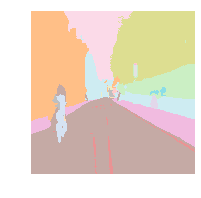

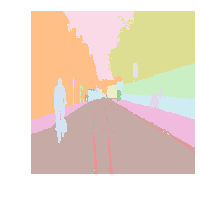

In [28]:
show_random_predictions(images, predictions, true_labels, 3)